## Tutorial: Fine-Tuning Whisper for French Telephone Conversations

Automatic Speech Recognition (ASR) systems like OpenAI’s Whisper deliver impressive out-of-the-box performance by leveraging an enormous, multilingual corpus. However, when your use case involves specialized vocabulary or languages that were underrepresented during pretraining, fine-tuning can make a significant difference. In particular, if your data diverges substantially from Whisper’s original training set—whether in domain, audio characteristics, or speaker demographics—adapting the model to your specific dataset often yields notable gains.

Below is the list of languages for which Whisper achieves a word error rate (WER) below 50%, an industry-standard threshold for speech-to-text accuracy:

Afrikaans, Arabic, Armenian, Azerbaijani, Belarusian, Bosnian, Bulgarian, Catalan, Chinese, Croatian, Czech, Danish, Dutch, English, Estonian, Finnish, French, Galician, German, Greek, Hebrew, Hindi, Hungarian, Icelandic, Indonesian, Italian, Japanese, Kannada, Kazakh, Korean, Latvian, Lithuanian, Macedonian, Malay, Marathi, Māori, Nepali, Norwegian, Persian, Polish, Portuguese, Romanian, Russian, Serbian, Slovak, Slovenian, Spanish, Swahili, Swedish, Tagalog, Tamil, Thai, Turkish, Ukrainian, Urdu, Vietnamese, and Welsh.

Although Whisper was pretrained on 98 languages in total, the list those where WER falls below 50%. For any languages not shown above, Whisper will still attempt transcription—but accuracy is expected to be substantially lower.

In this tutorial, we’ll walk through fine-tuning the Whisper **small** model specifically for French telephone conversations, using a dataset preprocessed by Diabolocom (Maheshwari et al., 2024). We chose the small variant of Whisper to keep the demonstration concise, but the same principles apply to larger or smaller model sizes. To make the process GPU-efficient and reduce the number of trainable parameters, we’ll employ Low-Rank Adaptation (LoRA) (Hu et al., 2021), which allows us to adapt Whisper even with limited hardware resources.

## 1. Install Dependencies

First, install all the Python libraries we’ll need for audio processing, dataset handling, training, evaluation, and a demo UI.

In [3]:
!pip install transformers peft torchaudio datasets accelerate gradio jiwer evaluate torchinfo

Looking in indexes: https://pypi.org/simple, https://pypi.diabolocom.ai


## 2. Setup & Authentication

Set your model identifiers and language parameters. Then authenticate with Hugging Face so you can download models and optionally push your adapter checkpoint.

In [1]:
model_name_or_path = "openai/whisper-small"
language = "French"
language_abbr = "fr"
task = "transcribe"

Your Hugging Face token can be found in [Hugging Face Hub.](https://huggingface.co/settings/tokens)

In [2]:
import os
from huggingface_hub import login

login()

## 3. Data Loading

We load a French telephone speech-to-text dataset processed by Diabolocom from Hugging Face Hub https://huggingface.co/datasets/diabolocom/talkbank_4_stt.

The dataset is structured into segment and switch parts, we are interested here into the segments and the "train" and "test" splits.

For this demo, we select only 1 000 samples from each split and ensure that audio is resampled to 16 kHz.

In [4]:
from datasets import load_dataset, DatasetDict, Audio

talkbank_fr = load_dataset(
    "diabolocom/talkbank_4_stt", 
    data_dir="fr/segment", 
    verification_mode="no_checks")

talkbank = DatasetDict({
    "train": talkbank_fr["train"].select(range(1000)), 
    "test": talkbank_fr["test"].select(range(1000))
})

talkbank = talkbank.cast_column("audio", Audio(sampling_rate=16000))

## 4. Explore the dataset

Let’s listen to a sample, inspect its duration and metadata, and plot the distribution of audio lengths in train vs. test.

In [5]:
def format_seconds(seconds_input):
    """
    Turn a number of seconds (possibly fractional) into a compact string,
    omitting zero-value day/hour/minute units, and always showing seconds (with
    up to millisecond precision, dropping trailing zeros).
    """
    remaining = float(seconds_input)
    parts = []
    for label, unit_secs in (("d", 86400), ("h", 3600), ("m", 60)):
        qty, remaining = divmod(remaining, unit_secs)
        if qty >= 1:
            parts.append(f"{int(qty)}{label}")
    parts.append(f"{remaining:.3f}s")
    
    return " ".join(parts)

In [6]:
import torch
from datasets import Audio
import IPython.display as ipd

id = 42
example = talkbank["test"][id]

audio_array = example["audio"]["array"]
sampling_rate = example["audio"]["sampling_rate"]

ipd.display(ipd.Audio(audio_array, rate=sampling_rate))

print(f"Duration: {format_seconds(audio_array.shape[0]/sampling_rate)}")
print(f"Language: {example['full_language']}")
print(f"subset: {example['subset']}")

Duration: 0.480s
Language: French - Quebecois
subset: CallFriend


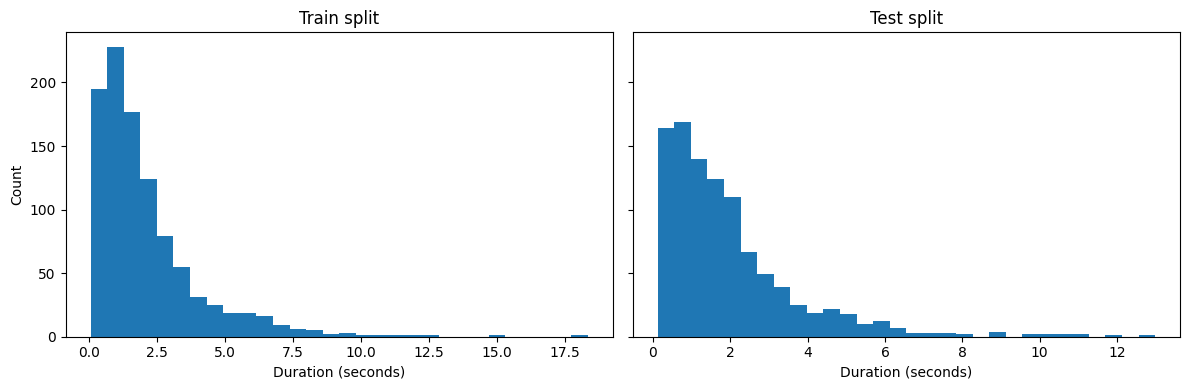

In [7]:
import matplotlib.pyplot as plt

durations = {}
for split in ["train","test"]:
    durations[split] = [
        ex["audio"]["array"].shape[0] / ex["audio"]["sampling_rate"]
        for ex in talkbank[split]
    ]

# two-panel histogram
fig, axes = plt.subplots(1, 2, figsize=(12, 4), sharey=True)
for ax, split in zip(axes, ["train","test"]):
    ax.hist(durations[split], bins=30)
    ax.set_title(f"{split.capitalize()} split")
    ax.set_xlabel("Duration (seconds)")
axes[0].set_ylabel("Count")
plt.tight_layout()
plt.show()

## 5. Preprocessing

Before we can fine-tune Whisper, we need to transform our raw dataset into exactly the inputs the model expects:  
1.  `input_features`: 80-dim log-Mel spectrogram frames.  
2.  `labels`: target tokenized transcripts

In [8]:
# Just clean up unneeded columns, keeping the audio and transcript
talkbank = talkbank.remove_columns([
    "language_code", "subset", "full_language",
    "switch_id", "transcript_filename", "orig_file_start",
    "orig_file_end", "channel"
])

In [9]:
from transformers import WhisperFeatureExtractor, WhisperTokenizer, WhisperProcessor

feature_extractor = WhisperFeatureExtractor.from_pretrained(model_name_or_path)
tokenizer = WhisperTokenizer.from_pretrained(model_name_or_path, language=language, task=task)
processor = WhisperProcessor.from_pretrained(model_name_or_path, language=language, task=task)

def prepare_dataset(batch):
    audio = batch["audio"]

    # compute log-Mel input features from input audio array
    batch["input_features"] = feature_extractor(audio["array"], sampling_rate=audio["sampling_rate"]).input_features[0]

    # encode target text to label ids
    batch["labels"] = tokenizer(batch["transcript"]).input_ids
    return batch

talkbank = talkbank.map(prepare_dataset, remove_columns=talkbank.column_names["train"], num_proc=1)

In [10]:
talkbank['train']

Dataset({
    features: ['input_features', 'labels'],
    num_rows: 1000
})

## 6. Data collator

Because audio and text lengths vary, we need a custom collator that pads inputs and labels separately and masks padding tokens in the loss.

In [11]:
import torch

from dataclasses import dataclass
from typing import Any, Dict, List, Union


@dataclass
class DataCollatorSpeechSeq2SeqWithPadding:
    processor: Any

    def __call__(self, features: List[Dict[str, Union[List[int], torch.Tensor]]]) -> Dict[str, torch.Tensor]:
        # split inputs and labels since they have to be of different lengths and need different padding methods
        # first treat the audio inputs by simply returning torch tensors
        input_features = [{"input_features": feature["input_features"]} for feature in features]
        batch = self.processor.feature_extractor.pad(input_features, return_tensors="pt")

        # get the tokenized label sequences
        label_features = [{"input_ids": feature["labels"]} for feature in features]
        # pad the labels to max length
        labels_batch = self.processor.tokenizer.pad(label_features, return_tensors="pt")

        # replace padding with -100 to ignore loss correctly
        labels = labels_batch["input_ids"].masked_fill(labels_batch.attention_mask.ne(1), -100)

        # if bos token is appended in previous tokenization step,
        # cut bos token here as it's append later anyways
        if (labels[:, 0] == self.processor.tokenizer.bos_token_id).all().cpu().item():
            labels = labels[:, 1:]

        batch["labels"] = labels

        return batch

data_collator = DataCollatorSpeechSeq2SeqWithPadding(processor=processor)

## 7. Load the Pre-Trained Model and Tokenizer
In this step we load the pre-trained Whisper model with 8-bit precision to save memory, and inspect its architecture.\
Then we disable forced tokens so generation follows our prompts.

In [12]:
from transformers import WhisperForConditionalGeneration

model = WhisperForConditionalGeneration.from_pretrained(model_name_or_path, load_in_8bit=True, device_map="auto")

from torchinfo import summary
summary(model)

The `load_in_4bit` and `load_in_8bit` arguments are deprecated and will be removed in the future versions. Please, pass a `BitsAndBytesConfig` object in `quantization_config` argument instead.


Layer (type:depth-idx)                                  Param #
WhisperForConditionalGeneration                         --
├─WhisperModel: 1-1                                     --
│    └─WhisperEncoder: 2-1                              --
│    │    └─Conv1d: 3-1                                 185,088
│    │    └─Conv1d: 3-2                                 1,770,240
│    │    └─Embedding: 3-3                              (1,152,000)
│    │    └─ModuleList: 3-4                             85,045,248
│    │    └─LayerNorm: 3-5                              1,536
│    └─WhisperDecoder: 2-2                              --
│    │    └─Embedding: 3-6                              39,832,320
│    │    └─WhisperPositionalEmbedding: 3-7             344,064
│    │    └─ModuleList: 3-8                             113,402,880
│    │    └─LayerNorm: 3-9                              1,536
├─Linear: 1-2                                           39,832,320
Total params: 281,567,232
Trainable params: 8

The model has arguments that we will override such as:

forced_decoder_ids (`List[List[int]]`, *optional*):
            A list of pairs of integers which indicates a mapping from generation indices to token indices that will be
            forced before sampling. For example, `[[1, 123]]` means the second generated token will always be a token
            of index 123.

suppress_tokens (`List[int]`, *optional*):
            A list of tokens that will be suppressed at generation. The `SupressTokens` logit processor will set their
            log probs to `-inf` so that they are not sampled.

In [13]:
print(f"model forced_decoder_ids: {model.config.forced_decoder_ids}")
print(f"model suppress_tokens: {model.config.suppress_tokens}")

model.config.forced_decoder_ids = None
model.config.suppress_tokens = []

model forced_decoder_ids: [[1, 50259], [2, 50359], [3, 50363]]
model suppress_tokens: [1, 2, 7, 8, 9, 10, 14, 25, 26, 27, 28, 29, 31, 58, 59, 60, 61, 62, 63, 90, 91, 92, 93, 359, 503, 522, 542, 873, 893, 902, 918, 922, 931, 1350, 1853, 1982, 2460, 2627, 3246, 3253, 3268, 3536, 3846, 3961, 4183, 4667, 6585, 6647, 7273, 9061, 9383, 10428, 10929, 11938, 12033, 12331, 12562, 13793, 14157, 14635, 15265, 15618, 16553, 16604, 18362, 18956, 20075, 21675, 22520, 26130, 26161, 26435, 28279, 29464, 31650, 32302, 32470, 36865, 42863, 47425, 49870, 50254, 50258, 50360, 50361, 50362]


## 8. LoRA Fine-Tuning ⚙️

We will now integrate **LoRA adapters** into our pre-trained Whisper model via the PEFT library. 

LoRA (“Low-Rank Adaptation”) freezes the original weights and learns only a small, **additive** low-rank update in selected layers. This reduces the number of trainable parameters and accelerates fine-tuning. 

Moreover, because the LoRA updates are stored separately, you can easily swap in different adapter checkpoints— for example, to support new languages or specialized domains—while keeping the same underlying base model.

In [14]:
from peft import LoraConfig, get_peft_model, TaskType

# Configure LoRA settings for sequence-to-sequence language modeling
lora_config = LoraConfig(
    r=8,                           # Rank of the low-rank matrices
    lora_alpha=32,                  # Scaling factor for LoRA updates
    lora_dropout=0.1,               # Dropout probability for LoRA layers
    target_modules=["q_proj", "v_proj"]  # Target modules in the Transformer to adapt (adjust as needed)
)

#Some models freeze embeddings by default; this ensures LoRA can adapt them if needed.
model.enable_input_require_grads()

# Wrap the model with LoRA adapters; this makes only the LoRA parameters trainable.
model = get_peft_model(model, lora_config)

# Optionally, print trainable parameters to verify that only the LoRA layers are being updated.
print("Trainable parameters after applying LoRA:")
model.print_trainable_parameters()


Trainable parameters after applying LoRA:
trainable params: 884,736 || all params: 242,619,648 || trainable%: 0.3647


## 9. Define the Evaluation Metric (WER)

We use the Word Error Rate (WER) to evaluate the performance of our speech recognition system.
The `compute_metrics` function decodes model predictions and ground-truth labels, computes the WER,
and returns it as a percentage.

In [15]:
import evaluate

# Load the WER metric from the evaluate library
metric = evaluate.load("wer")

def compute_metrics(pred):
    """
    Compute Word Error Rate (WER) for model predictions.
    
    Args:
        pred: The prediction output from the trainer containing predictions and label_ids.
    
    Returns:
        A dictionary containing the WER score.
    """
    pred_ids = pred.predictions
    label_ids = pred.label_ids

    # replace -100 with the pad_token_id
    label_ids[label_ids == -100] = tokenizer.pad_token_id

    # we do not want to group tokens when computing the metrics
    pred_str = tokenizer.batch_decode(pred_ids, skip_special_tokens=True)
    label_str = tokenizer.batch_decode(label_ids, skip_special_tokens=True)

    wer = 100 * metric.compute(predictions=pred_str, references=label_str)

    return {"wer": wer}

## 10. Setup Training Arguments

We use Hugging Face's Seq2SeqTrainingArguments to define our training configuration.
These settings include batch size, learning rate, number of steps, evaluation strategy, and logging.


In [ ]:
from transformers import Seq2SeqTrainingArguments

training_args = Seq2SeqTrainingArguments(
    output_dir="results",
    per_device_train_batch_size=8,
    gradient_accumulation_steps=1,
    learning_rate=1e-3,
    warmup_steps=50,
    num_train_epochs=3,
    evaluation_strategy="epoch",
    fp16=True,
    per_device_eval_batch_size=8,
    generation_max_length=128,
    logging_steps=25,
    remove_unused_columns=False,  #required for the PeftModel forward
    label_names=["labels"],  #same reason as above
    report_to=["none"],  # Disable logging to avoid cluttering the output
    )   

/root/miniconda3/envs/canary/lib/python3.10/site-packages/transformers/training_args.py:1575: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


## 11. Initialize the Trainer

We instantiate Hugging Face's Seq2SeqTrainer with our model, training arguments, datasets and
data collator. 

We are just using the first 100 segments for demonstration, if you want production-quality transcription, you should continue fine-tuning with a larger dataset and more training time.


In [ ]:
from transformers import Seq2SeqTrainer

trainer = Seq2SeqTrainer(
    args=training_args,
    model=model,
    train_dataset=talkbank["train"].select(range(100)),
    eval_dataset=talkbank["test"].select(range(100)),
    data_collator=data_collator,
    tokenizer=processor.feature_extractor,
)

/tmp/ipykernel_45417/2961733102.py:3: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Seq2SeqTrainer.__init__`. Use `processing_class` instead.
  trainer = Seq2SeqTrainer(


## 12. Fine-Tune the Model

We now start the training process. The trainer will fine-tune the model using the LoRA adapters,
updating only the LoRA-specific parameters.

In [26]:
trainer.train()

Epoch,Training Loss,Validation Loss
1,No log,3.890726
2,3.955700,2.560604
3,3.955700,1.943963


/root/miniconda3/envs/canary/lib/python3.10/site-packages/bitsandbytes/autograd/_functions.py:315: UserWarning: MatMul8bitLt: inputs will be cast from torch.float32 to float16 during quantization
  warnings.warn(f"MatMul8bitLt: inputs will be cast from {A.dtype} to float16 during quantization")


TrainOutput(global_step=39, training_loss=3.2936521676870494, metrics={'train_runtime': 82.7204, 'train_samples_per_second': 3.627, 'train_steps_per_second': 0.471, 'total_flos': 8.6957826048e+16, 'train_loss': 3.2936521676870494, 'epoch': 3.0})

**(Optional)** Push the model on the Hugging Face Hub

In [27]:
model_name_or_path = "openai/whisper-small"
peft_model_id = "diabolocom/" + f"{model_name_or_path}-LoRA".replace("/", "-")
model.push_to_hub(peft_model_id)
print(peft_model_id)

README.md:   0%|          | 0.00/5.17k [00:00<?, ?B/s]

adapter_model.safetensors:   0%|          | 0.00/3.56M [00:00<?, ?B/s]

diabolocom/openai-whisper-small-LoRA


## 13. Evaluation

In this section we load our PEFT‐LoRA-fine-tuned Whisper model, run it on the test split, and compute the Word Error Rate (WER) metric.

In [28]:
from peft import PeftModel, PeftConfig
from transformers import WhisperForConditionalGeneration, Seq2SeqTrainer

peft_model_id = "diabolocom/openai-whisper-small-LoRA"
peft_config = PeftConfig.from_pretrained(peft_model_id)
model = WhisperForConditionalGeneration.from_pretrained(
    peft_config.base_model_name_or_path, load_in_8bit=True, device_map="auto"
)
model = PeftModel.from_pretrained(model, peft_model_id)

adapter_config.json:   0%|          | 0.00/896 [00:00<?, ?B/s]

The `load_in_4bit` and `load_in_8bit` arguments are deprecated and will be removed in the future versions. Please, pass a `BitsAndBytesConfig` object in `quantization_config` argument instead.


adapter_model.safetensors:   0%|          | 0.00/3.56M [00:00<?, ?B/s]

In [ ]:
from torch.utils.data import DataLoader
from tqdm import tqdm
import numpy as np
import gc

eval_dataloader = DataLoader(talkbank["test"], batch_size=8, collate_fn=data_collator)

model.eval()
for step, batch in enumerate(tqdm(eval_dataloader)):
    with torch.cuda.amp.autocast():
        with torch.no_grad():
            generated_tokens = (
                model.generate(
                    input_features=batch["input_features"].to("cuda"),
                    decoder_input_ids=batch["labels"][:, :4].to("cuda"),
                    max_new_tokens=255,
                )
                .cpu()
                .numpy()
            )
            labels = batch["labels"].cpu().numpy()
            labels = np.where(labels != -100, labels, tokenizer.pad_token_id)
            decoded_preds = tokenizer.batch_decode(generated_tokens, skip_special_tokens=True)
            decoded_labels = tokenizer.batch_decode(labels, skip_special_tokens=True)
            metric.add_batch(
                predictions=decoded_preds,
                references=decoded_labels,
            )
    del generated_tokens, labels, batch
    gc.collect()
wer = 100 * metric.compute()
print(f"{wer=}")

## 14. Demonstration with Gradio

Here we build a simple web interface so users can speak into their microphone and see live transcription from our PEFT-LoRA Whisper model.

This French‐language Whisper-small model includes LoRA adapters to illustrate the fine-tuning process. 

It isn’t fully trained, if you want production-quality transcription, you should continue fine-tuning with a larger dataset and more training time.

In [29]:
import torch
import gradio as gr
from transformers import (
    AutomaticSpeechRecognitionPipeline,
    WhisperForConditionalGeneration,
    WhisperTokenizer,
    WhisperProcessor,
)
from peft import PeftModel, PeftConfig


peft_model_id = "diabolocom/openai-whisper-small-LoRA"
language = "French"
task = "transcribe"
peft_config = PeftConfig.from_pretrained(peft_model_id)
model = WhisperForConditionalGeneration.from_pretrained(
    peft_config.base_model_name_or_path, load_in_8bit=True, device_map="auto"
)

model = PeftModel.from_pretrained(model, peft_model_id)
tokenizer = WhisperTokenizer.from_pretrained(peft_config.base_model_name_or_path, language=language, task=task)
processor = WhisperProcessor.from_pretrained(peft_config.base_model_name_or_path, language=language, task=task)
feature_extractor = processor.feature_extractor
forced_decoder_ids = processor.get_decoder_prompt_ids(language=language, task=task)
pipe = AutomaticSpeechRecognitionPipeline(model=model, tokenizer=tokenizer, feature_extractor=feature_extractor)


def transcribe(audio):
    with torch.cuda.amp.autocast():
        text = pipe(audio, generate_kwargs={"forced_decoder_ids": forced_decoder_ids}, max_new_tokens=255)["text"]
    return text


iface = gr.Interface(
    fn=transcribe,
    inputs=gr.Audio(sources=["microphone"], type="filepath"),
    outputs="text",
    title="PEFT LoRA",
    description="Tutorial demo only: this French‐language Whisper-small model includes LoRA adapters to illustrate the fine-tuning process. It isn’t fully trained—if you want production-quality transcription, you should continue fine-tuning with a larger dataset and more training time.",
)

iface.launch(share=True)

The `load_in_4bit` and `load_in_8bit` arguments are deprecated and will be removed in the future versions. Please, pass a `BitsAndBytesConfig` object in `quantization_config` argument instead.
Device set to use cuda:0


* Running on local URL:  http://127.0.0.1:7860
* Running on public URL: https://9cd5f0c486285ae32d.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)


## References

[1] G. Maheshwari, D. Ivanov, T. Johannet, and K. E. Haddad, “ASR Benchmarking: Need for a More Representative Conversational Dataset,” Sep. 18, 2024, arXiv: arXiv:2409.12042. doi: 10.48550/arXiv.2409.12042.

[2] E. J. Hu et al., “LoRA: Low-Rank Adaptation of Large Language Models,” Oct. 16, 2021, arXiv: arXiv:2106.09685. doi: 10.48550/arXiv.2106.09685.

